# *Librerias* 

In [12]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# *Datasets IRIS*

In [4]:
iris = datasets.load_iris()

In [5]:
#arreglo de caracteristicas

array_features = iris.data
features_tensor = torch.tensor(array_features,dtype=torch.float)

#arreglo de etiquetas

array_label = iris.target
labels_tensor = torch.tensor(array_label, dtype=torch.uint8)

# *Función mask*

- La funcion genera una lista con valores True y False que será util mas adelante para decir con que porcentaje de los objetos del dataset se entrenara el modelo y al final genera una lista con los objetos resultantes para hacer el test.



In [6]:
def mask(Y_iris, porc_train):
  val_train = len(Y_iris) * porc_train
  val_train_round = round(val_train)
  
  list_train = [True if i < val_train_round else False for i in range(len(Y_iris))]
  random.shuffle(list_train)

  list_test = np.invert(list_train)

  return torch.tensor(list_train),torch.tensor(list_test)

#*Creacion del grafo con pytorchgeometric*

In [7]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

In [8]:
#Se crea los fetures de los nodos

x = features_tensor

#Labels nodes

y = labels_tensor

#Datos de entrenamiento y test

train_mask, test_mask = mask(array_label, 0.3)


edge_index = knn_graph(x, k=4, batch=y, loop=False)


#Creacion del grafo 

data = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask, test_mask = test_mask )# edge_index tensor que define los nodos de origen y desdetino.

#*Visualizacion del grafo*

In [10]:
def plot_dataset(dataset):

  edges_raw = data['edge_index'].numpy()
  edge = list(zip(edges_raw[0, :], edges_raw[1, :]))
  nodes = list(range(np.max(edges_raw)))
  labels = data['y'].numpy()

  G = nx.Graph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edge)
  #nx.draw(G, with_labels=True, node_color=labels)

  option = {'figsize':(20.0,10.0)}
  plt.subplots(0,0, **option)
  options = {
                'node_size': 50,
                'width': 0.1,
      }
  nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
  
  plt.show()

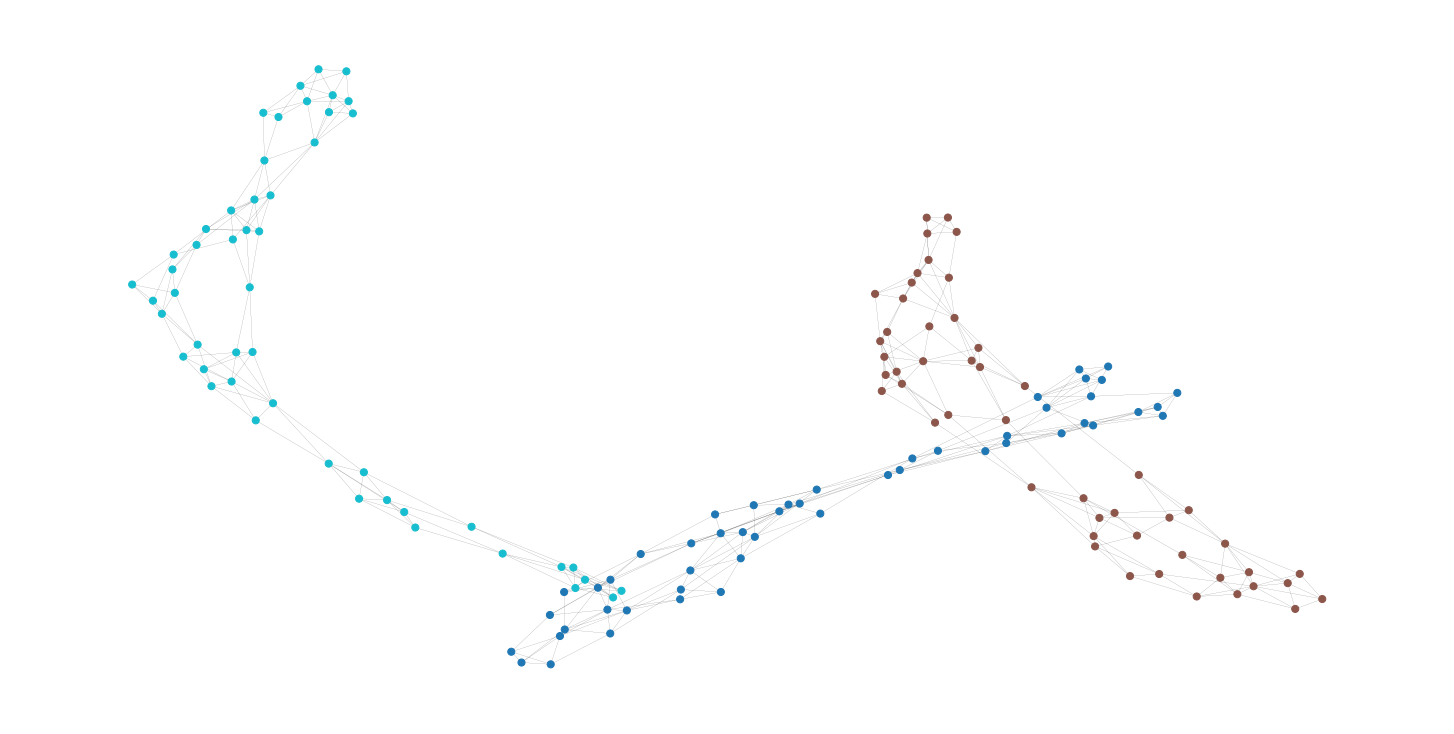

In [11]:
plot_dataset(data)

In [14]:
data.to(device)

Data(x=[150, 4], edge_index=[2, 600], y=[150], train_mask=[150], test_mask=[150])

# *Modelos*

In [15]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

In [73]:
def accuracy(pred_y, y):
   
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[data.test_mask], data.y[data.test_mask])
    return acc

def train(model, data, epochs):
    """Train a GNN model and return the trained model."""
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs+1):
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = f_loss(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f}')
          
    return model

## *GAT*

In [81]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.3, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.1, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

In [82]:
# Create GAT
gat = GAT(4, 9, 3).to(device)

# Train
train(gat, data, epochs = 100)

# Test
ac = test(gat, data)
print(f"================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.342
Epoch  10 | Train Loss: 0.531
Epoch  20 | Train Loss: 0.390
Epoch  30 | Train Loss: 0.323
Epoch  40 | Train Loss: 0.312
Epoch  50 | Train Loss: 0.272
Epoch  60 | Train Loss: 0.301
Epoch  70 | Train Loss: 0.307
Epoch  80 | Train Loss: 0.177
Epoch  90 | Train Loss: 0.109
Epoch 100 | Train Loss: 0.106
Accuracy: 95.24%


## *GCN*

In [98]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.3, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.1, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

In [99]:
gcn = GCN(4, 9, 3).to(device)

# Train
train(gcn, data, epochs = 100)

# Test
ac = test(gcn, data)
print(f"================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 4.953
Epoch  10 | Train Loss: 2.669
Epoch  20 | Train Loss: 1.068
Epoch  30 | Train Loss: 0.804
Epoch  40 | Train Loss: 0.587
Epoch  50 | Train Loss: 0.588
Epoch  60 | Train Loss: 0.485
Epoch  70 | Train Loss: 0.513
Epoch  80 | Train Loss: 0.423
Epoch  90 | Train Loss: 0.389
Epoch 100 | Train Loss: 0.436
Accuracy: 65.71%


## *GraphSage*

In [103]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.3)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.1)
        h = self.conv2(h, edge_index)
       
        return h

In [104]:
g_sage = GraphSAGE(4, 9, 3).to(device)

# Train
train(g_sage, data, epochs = 100)

# Test
ac = test(g_sage, data)
print(f"================================\nAccuracy: {ac*100:.2f}%")

Epoch   0 | Train Loss: 1.746
Epoch  10 | Train Loss: 0.991
Epoch  20 | Train Loss: 0.963
Epoch  30 | Train Loss: 0.765
Epoch  40 | Train Loss: 0.544
Epoch  50 | Train Loss: 0.601
Epoch  60 | Train Loss: 0.650
Epoch  70 | Train Loss: 0.389
Epoch  80 | Train Loss: 0.428
Epoch  90 | Train Loss: 0.342
Epoch 100 | Train Loss: 0.313
Accuracy: 82.86%
